# Chat with Professor Tippett (4/6)

## Real-time estimation of $R_t$ ...

### Stochastic SIR model
\begin{align*}
\frac{dS}{dt} &= -\beta(t) \frac{SI}{N} \\
\frac{dI}{dt} &= \beta(t) \frac{SI}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{align*}
using a time step $dt = 1$,
\begin{align*}
dSI &\sim  \operatorname{Poisson}\left(\beta(t) \frac{SI}{N}\right) \\
dIR &\sim \operatorname{Poisson}\left(\gamma I\right)
\end{align*}

### Functional form for $R_t$
$$
R_t=R^{\text {before }}+\frac{R^{a f t e r}-R^{b e f o r e}}{1+e^{-k(t-m)}}
$$
$$
\beta(t) = \gamma R_t
$$

### Priors
- $R^{\text {before }} \sim U\left(a_{\text {before }}, b_{b e f o r e}\right)$
- $R^{a f t e r} \sim U\left(a_{a f t e r}, b_{a f t e r}\right)$
- $k \sim U(a, b)$
- $m \sim U\left(0, n_t\right)$


## Generate Synthetic Data

In [68]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

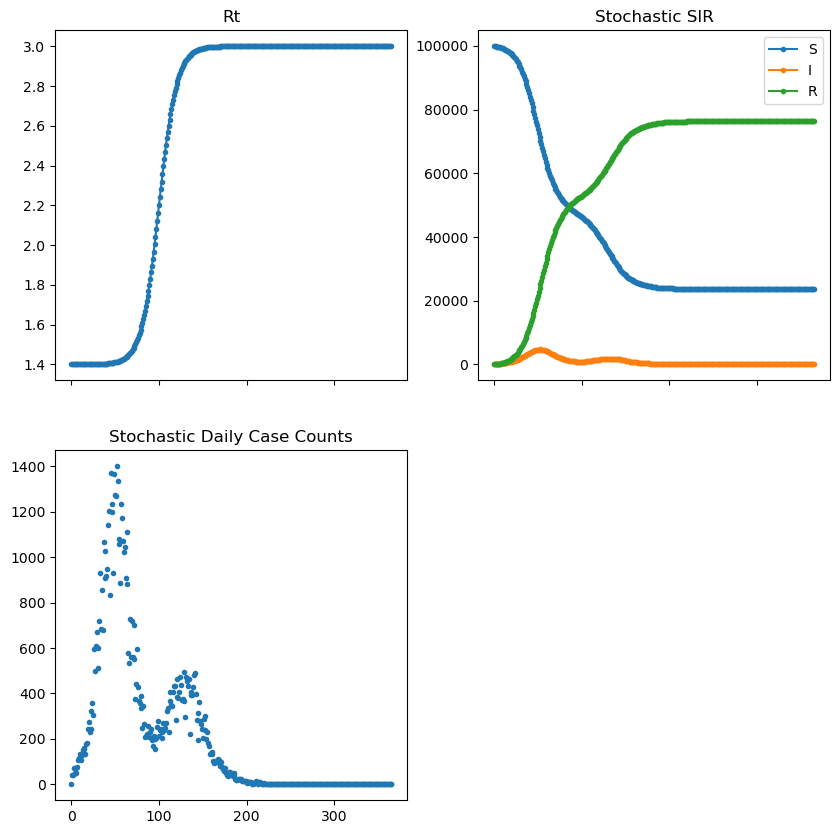

In [69]:
import importlib
import simulate_data
importlib.reload(simulate_data)

true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()

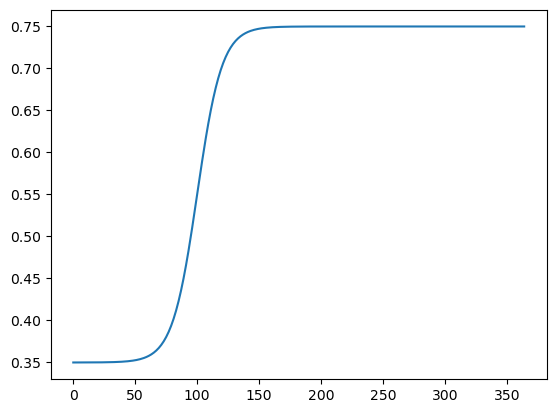

In [70]:
plt.plot(data.construct_beta(data.rt, data.t_I))

## MCMC (MH and NUTS) 

In [71]:
import pymc as pm
print(f"pyMC version: {pm.__version__}")

import scipy.stats

import logging

import pytensor
import pytensor.tensor as pt
from pytensor import scan
# pytensor.config.floatX = "float64"

from datetime import date
import os
import model
importlib.reload(model)

sir_model = model.SIR_model(data)

likelihood = {
    # 'dist': 'students-t', 
    # 'nu': 4,
    # 'sigma': 0.2,
    # 'min_sigma': 10,
    'dist': 'normal',
    # 'sigma': 0.2,
    # 'min_sigma': 10,
    # 'dist': 'negbin',
}
prior = {
    'rt_0':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['rt_0'],
        # }
        'dist': pm.Uniform,
        'args':{
        'lower': 1.,
        'upper': 4.,
        }
    },
    'rt_1':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['rt_1'],
        # }
        'dist': pm.Uniform,
        'args': {
            'lower': 1.5,
            'upper': 4.,
        }
    },
    'k':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['k'],
        # }
        'dist': pm.Uniform,
        'args': {
            'lower': 0.01,
            'upper': 2,
        }
    },
    'midpoint':{
        # 'dist': "constant",
        # 'args': {
        #     'value': true_params['midpoint'],
        # }
        'dist': pm.Uniform,
        'args': {
            'lower': 30,
            'upper': 200,
        }
    },
    'I0':{
        # 'dist': pm.Poisson,
        'dist': pm.Uniform,
        'args': {
            # 'mu': 50,
            'lower': 70,
            'upper': 200
        }
    },
}

method = 'metropolis'
n_samples = 50000
n_tune = 10000

vars = []
for k,v in prior.items():
    if v['dist'] != "constant":
        vars.append(k)

today = date.today() 
name = f"{method}_likelihood_{likelihood['dist']}"
path = os.path.abspath(f'../data/{today}_{name}')

print(name)

pyMC version: 5.0.2
metropolis_likelihood_normal


In [72]:
# sir_model.run_SIR_model(n_samples=n_samples, n_tune=n_tune, likelihood=likelihood, prior=prior, method=method, path=path)

In [73]:
import pickle

basepath = '/Users/hwunrow/Documents/GitHub/rt-estimation/data/'

with open(f"{basepath}/2023-02-05_NUTS_likelihood_normal_add_noise_in_mcmc_clip_before_noise/model.pkl", 'rb') as file:
        sir_model = pickle.load(file)

In [74]:
import arviz as az

vars = ['rt_0', 'rt_1', 'k', 'midpoint', 'I0']
az.summary(sir_model.trace, var_names=vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rt_0,1.405,0.006,1.394,1.417,0.000,0.000,906.0,2467.0,1.00
rt_1,2.977,0.098,2.787,3.153,0.008,0.005,161.0,578.0,1.03
k,0.107,0.009,0.090,0.124,0.001,0.001,118.0,256.0,1.04
midpoint,99.640,0.645,99.000,101.000,0.074,0.053,78.0,70.0,1.06
I0,115.237,5.400,104.000,124.000,0.221,0.156,599.0,1323.0,1.01


Percent of observations in 95% CI 0.9698630136986301
Percent of observations in 50% CI 0.5972602739726027


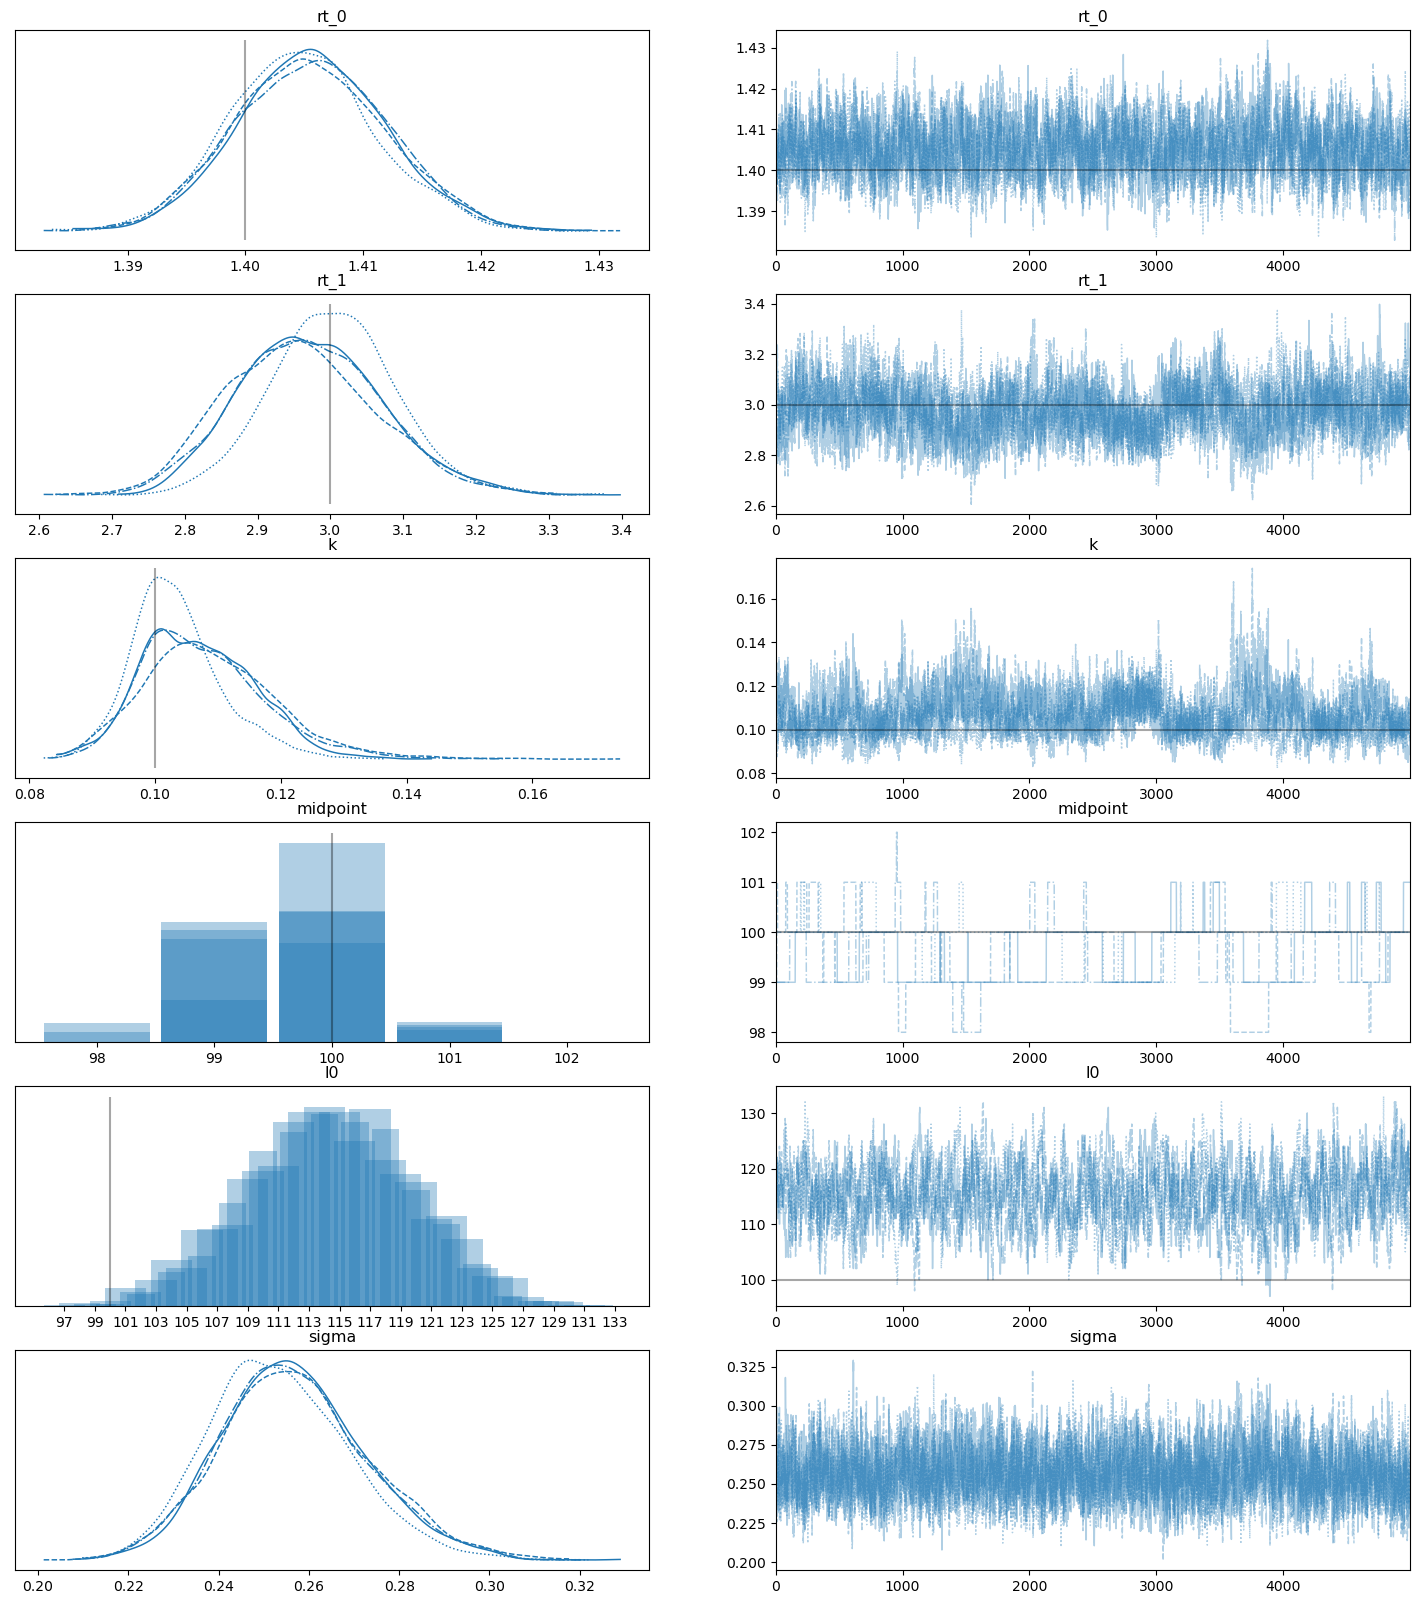

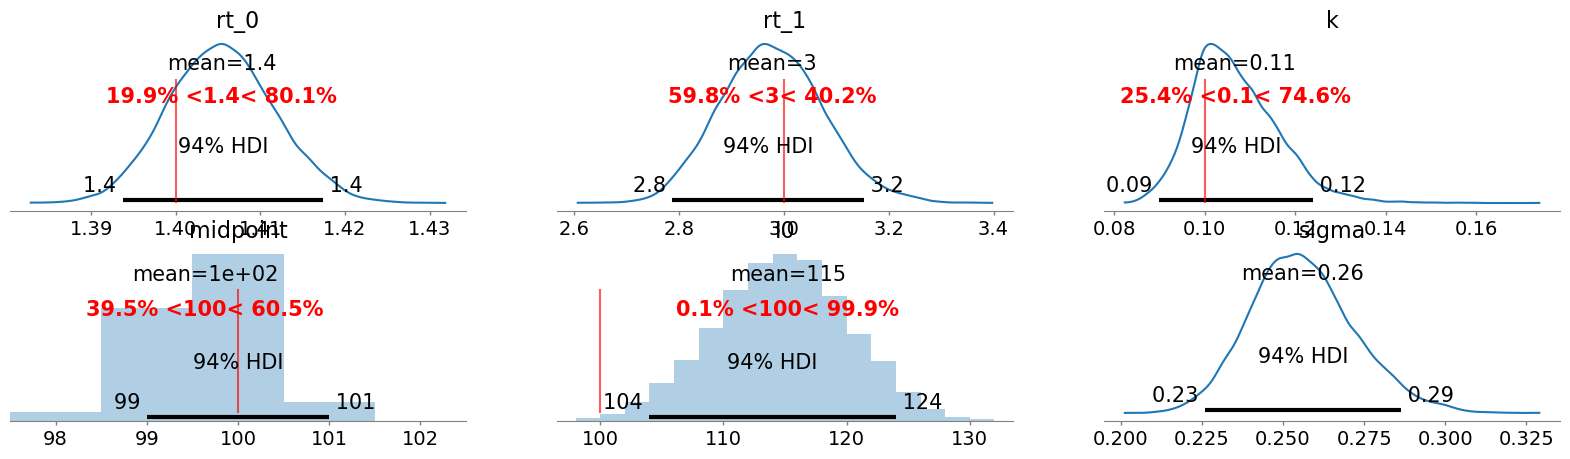

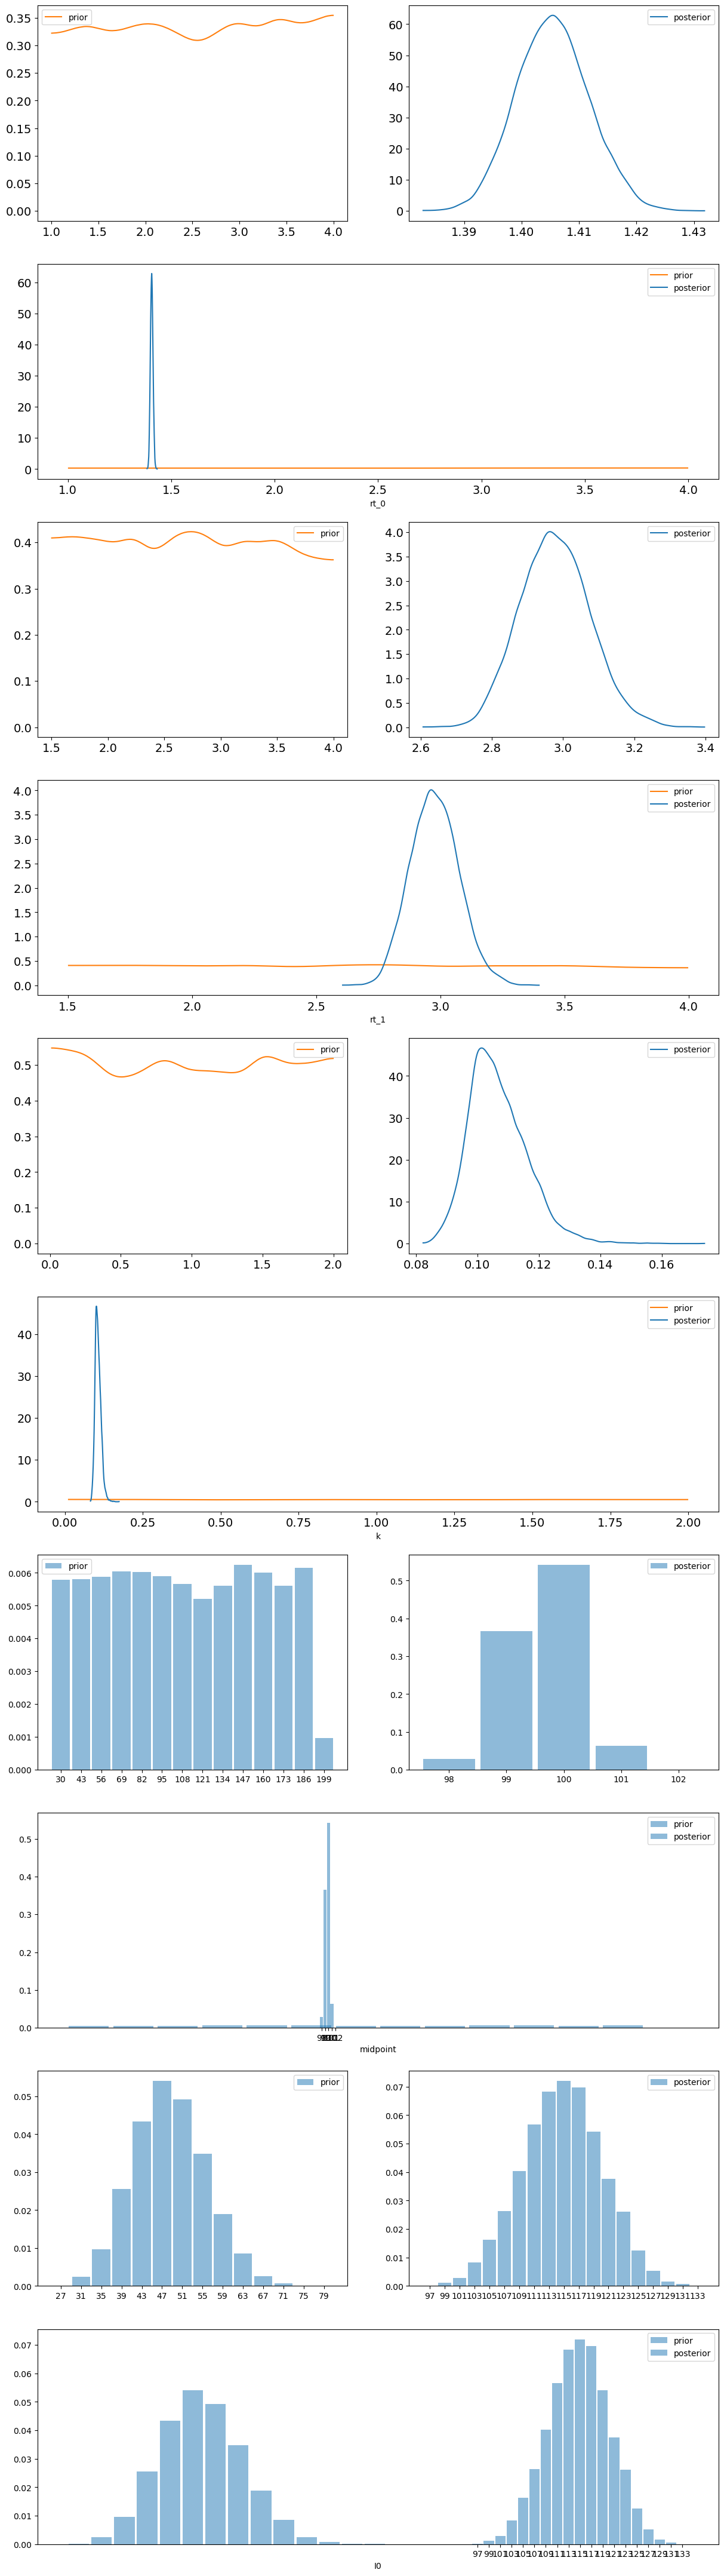

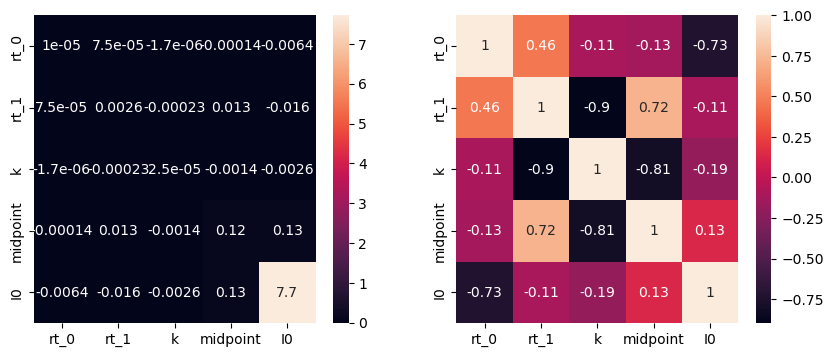

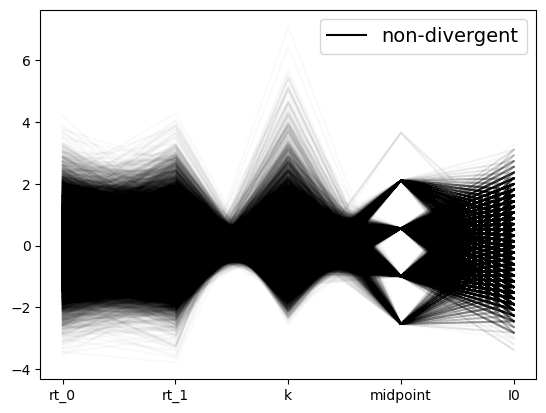

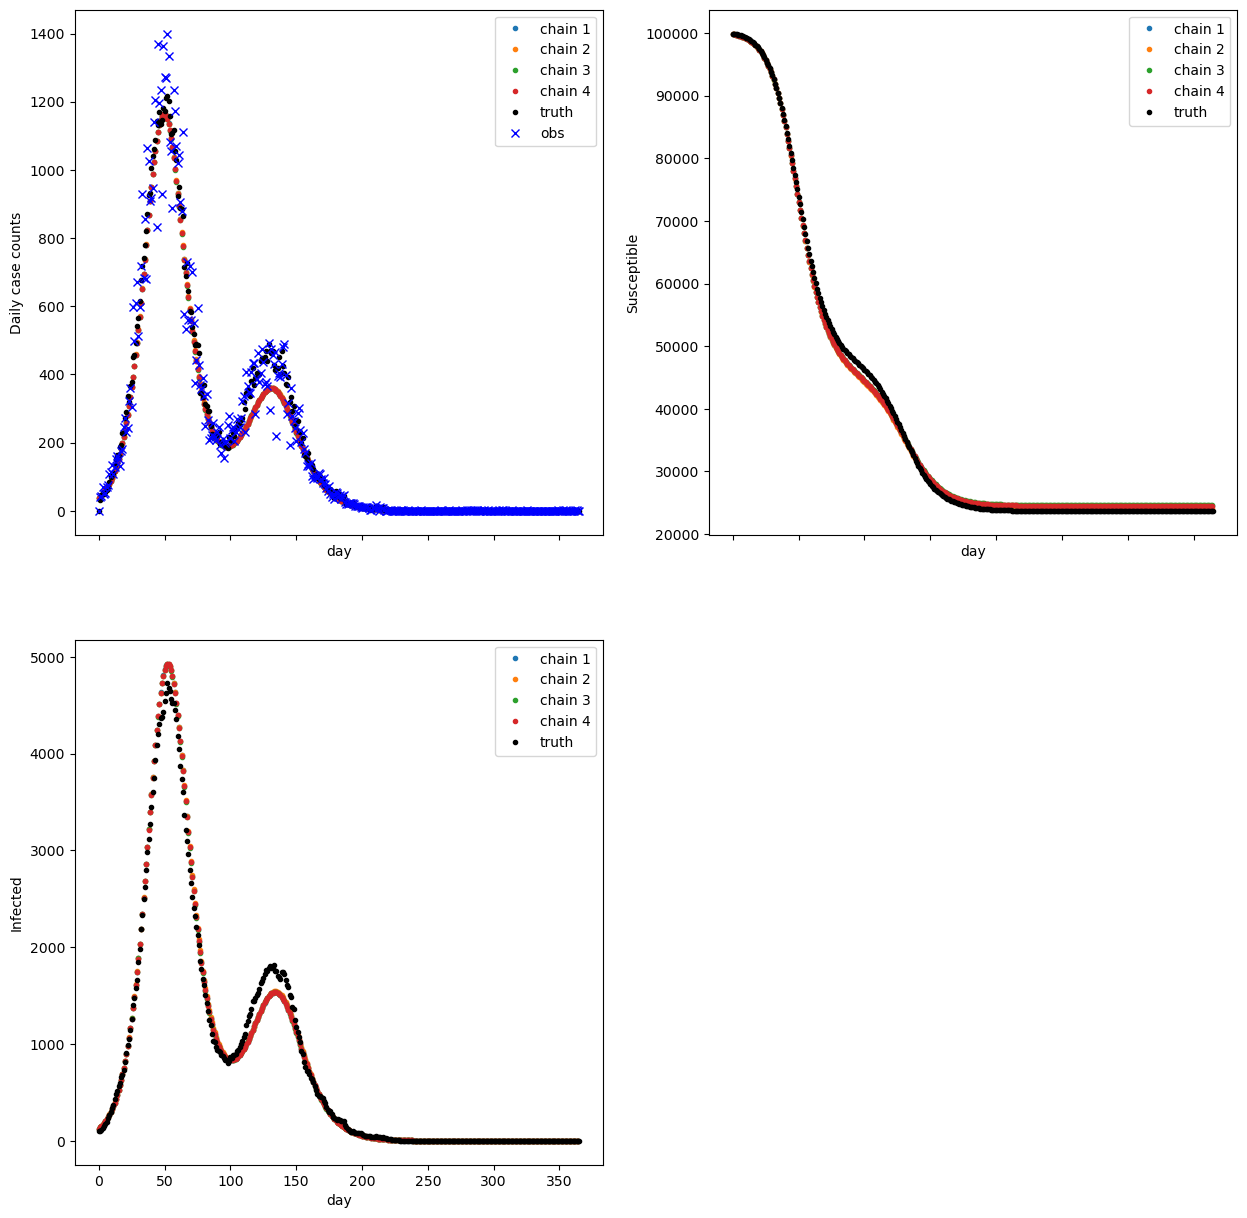

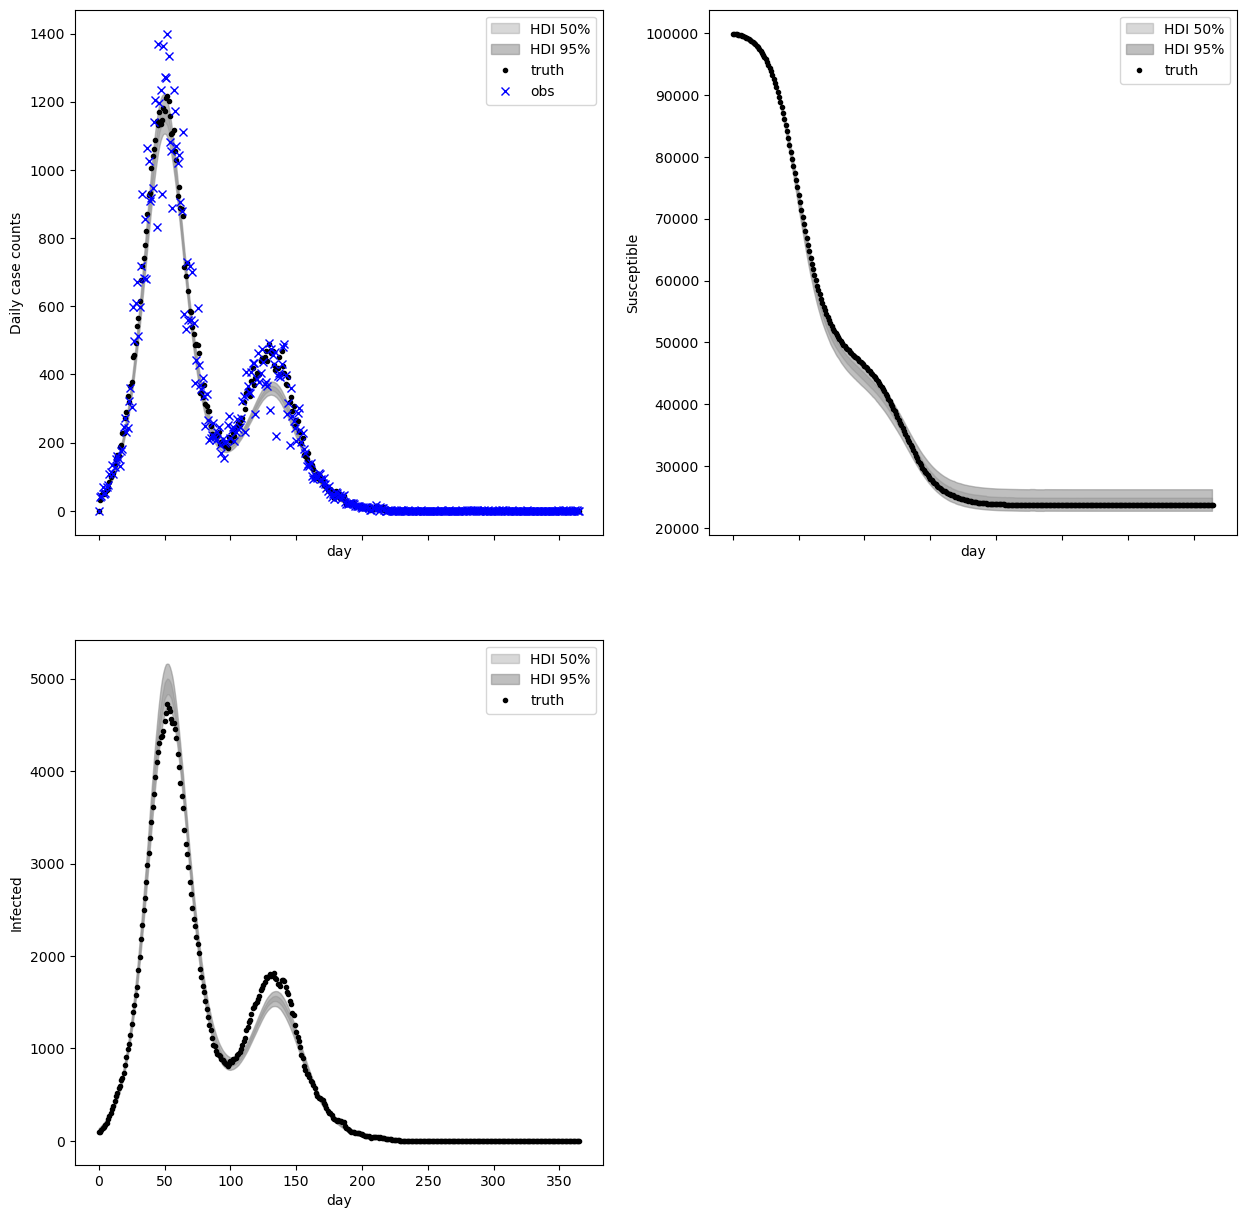

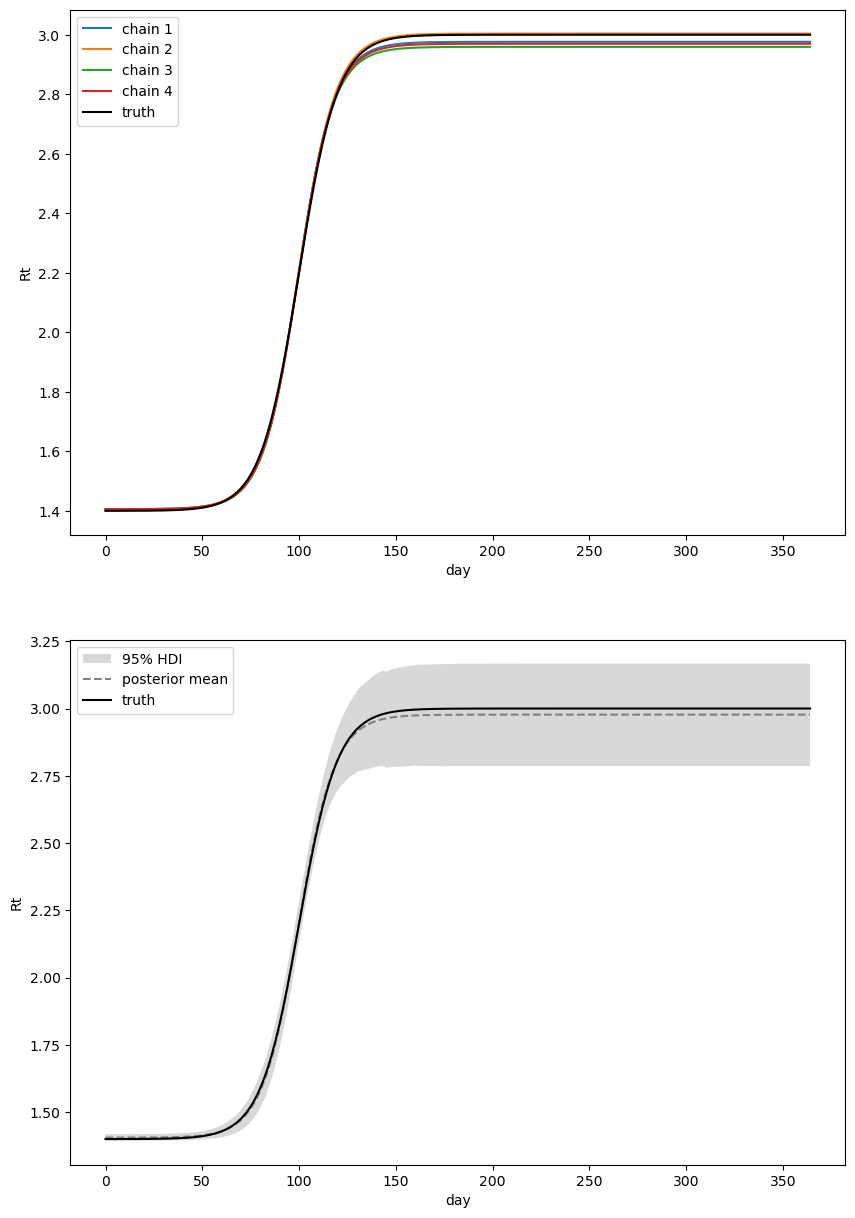

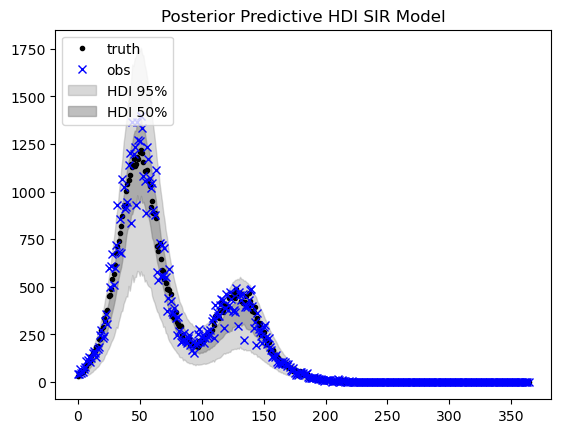

In [75]:
sir_model.plot_all(vars, path)

## EAKF

In [76]:
import collections

SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'S',              # S
    'I',               # I
    'R',                # R
    'i'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      't_I'   # t_I = 1/gamma
    ]
)

beta = data.construct_beta(data.rt, data.t_I)

x = SIR(
    S = data.S0,
    I = data.I0,
    R = 0,
    i = 0
)
θ = ModelParams(beta, data.t_I)

In [77]:
def f(t, x, θ, N, dt=1, noise_param=1/25):
    """
    State transition function.
        Args:
            t: time
            x: state space
            θ: parameters
            N: population
            dt: time step in days
    """

    # Stochastic transitions
    dSI = np.random.poisson(x.S * x.I/ N * θ.beta) # susceptible to infected
    dIR = np.random.poisson(x.I / θ.t_I) # infected to recovered
    
    # OEV = np.maximum(1., dSI**2 * noise_param)
    # OEV_sample= np.random.normal(0, 1, size=len(dSI))
    # i_noise = dSI + OEV_sample * np.sqrt(OEV)

    # Updates
    x_new = SIR(
        S = np.clip(x.S - dSI, 0, N),
        I = np.clip(x.I + dSI - dIR, 0, N),
        R = np.clip(x.R + dIR, 0, N),
        i = np.clip(dSI, 0, N)
    )

    return x_new

def g(x, α):
    """
    Observational function.
        Args:
            x: state space
            α: report rate
    """
    y = np.random.binomial(x.i.astype(int), α)
    return y

def f0(pop, m=300):
    """
    Initial guess of the state space.
        Args:
            pop: population
            m: number of ensemble members
    """
#     I0 = pop * inf_init
#     S0 = pop - I0
#     R0 = 0
#     i = 0

    S0 = np.random.uniform(pop*0.8, pop, size=m)
    I0 = pop - S0
    R0 = np.zeros(m)
    i0 = np.zeros(m)
    
    x0 = SIR(
        S = S0,
        I = I0,
        R = R0,
        i = i0
    )
    return x0

def θ0(prior, m=300):
    """
    Initial guess of the parameter space.
        Args:
            prior: prior
            m: number of ensemble members
    """
    beta = prior['beta']['dist'](**prior['beta']['args'], size=m)
    θ0 = ModelParams(beta=beta, t_I=np.ones(m)*data.t_I)
    return θ0

def eakf(x, y, z, oev):
    """
    Args:
        x: latenet state rv or latent parameter rv
        y: observed rv
        z: observation
        oev: observational error variance
    """
    x = np.array(x)
    y = np.array(y)
    
    p, m = x.shape

    mu_prior  = y.mean()
    var_prior = y.var()

    # degenerate prior.
    var_prior = np.where(var_prior == 0., 1e-3, var_prior)

    var_post = var_prior * oev / (var_prior + oev)
    mu_post  = var_post  * (mu_prior/var_prior + z/oev)
    alpha    = (oev / (oev + var_prior)) ** (0.5)
    dy       = (mu_post - y) + alpha * (y - mu_prior)
    
    # compute covariance
    rr = np.full((p, 1), np.nan)

    # import pdb; pdb.set_trace()
    for ip in range(p):
        A  = np.cov(x[ip, :], y)
        rr[ip,:] =  A[1, 0] / var_prior
    dx = np.dot(rr, dy.reshape((1,300)))
    # rr = np.cov(x, y)[:-1,-1] / var_prior
    # dx_new = np.dot(rr.reshape((4,1)), dy.reshape((1,300)))

    xpost = x + dx
    ypost = y + dy

    return xpost, ypost

In [78]:
from numpy.random import uniform

prior = {
    'beta':{
        'dist': uniform,
        'args':{
            'low': 0.1,
            'high': 2.,
        }
    },
    't_I':{
        'dist': "constant",
        # 'args':{
        #     'lower': 1.,
        #     'upper': 12.,
        # }
    },
}

In [95]:
from tqdm import tqdm

x_list = []
θ_list = []

for t, date in enumerate(range(data.n_t)):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        # noise_param = 1/100
        # oev = np.random.normal(0, 1) * np.maximum(1., z * noise_param)
        # oev = np.maximum(10, z**2/50)
        oev = np.maximum(1., z**2 /25)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

Text(0.5, 0.98, 'EAKF full time series no inflation')

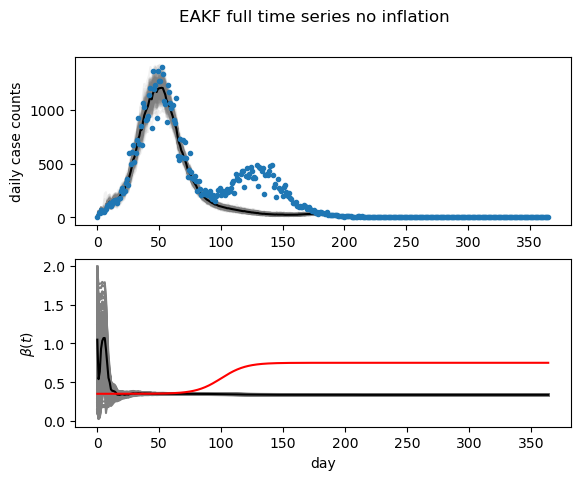

In [96]:
fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')
ax[0].set_ylabel('daily case counts')


ax[1].plot([θ.beta for θ in θ_list], color="gray")
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF full time series no inflation')

### Try adding inflation

In [81]:
def inflate_ensembles(ens, inflation_value=1.2):
    _, m = np.asarray(ens).shape
    ens_mean = np.mean(ens, 1, keepdims=True)
    return ens_mean * np.ones((1,m)) + inflation_value*(ens - ens_mean*np.ones((1,m)))

In [127]:
from tqdm import tqdm

x_list = []
θ_list = []

for t, date in tqdm(enumerate(range(data.n_t))):
    if t == 0:
        x = f0(data.N)
        θ = θ0(prior)
    else:
        if (50 < t) & (t < 200) & (t % 2 == 0):
            # x = SIR(*inflate_ensembles(x, inflation_value=1.2))
            # x = SIR(
            #     S = np.clip(x.S, 0, data.N),
            #     I = np.clip(x.I, 0, data.N),
            #     R = np.clip(x.R, 0, data.N),
            #     i = np.clip(x.i, 0, data.N)
            # )
            θ = inflate_ensembles(θ, inflation_value=1.2)
            θ = np.clip(θ, 0, 10)
            θ = ModelParams(*θ)
            
        x = f(t, x, θ, data.N)  # prediction
        y = g(x, α=1)           # analysis
        z = data.i[t]
        
        # oev = np.maximum(10, z**2/50)
        oev = np.maximum(1., z**2 /25)
        x, new_i = eakf(x, y, z, oev=oev)
        x = SIR(*x)
        x = x._replace(i=new_i)
        x = SIR(
            S = np.clip(x.S, 0, data.N),
            I = np.clip(x.I, 0, data.N),
            R = np.clip(x.R, 0, data.N),
            i = np.clip(x.i, 0, data.N)
        )
        θ, _ = eakf(θ, y, z, oev=oev)
        θ = np.clip(θ, 0, None)
        θ = ModelParams(*θ)
    
    x_list.append(x)
    θ_list.append(θ)

365it [00:00, 2396.57it/s]


Text(0.5, 0.98, 'EAKF full time series with inflation 20%')

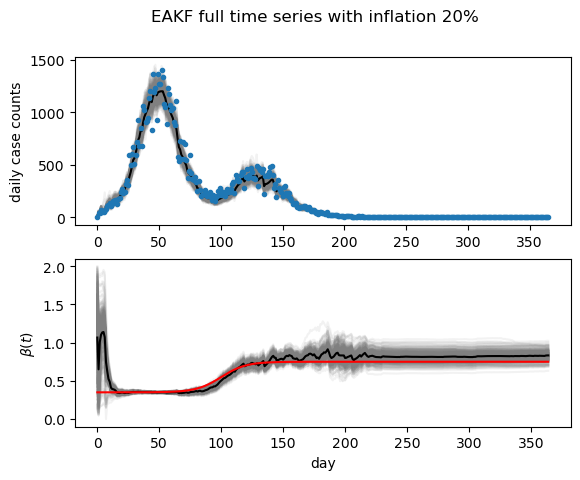

In [128]:
fig, ax = plt.subplots(2)
ax[0].plot([x.i for x in x_list], color='gray', alpha=0.1)
ax[0].plot(np.mean([x.i for x in x_list], axis=1), color='black')
ax[0].plot(data.i, '.')
ax[0].set_ylabel('daily case counts')

ax[1].plot([θ.beta for θ in θ_list], color="gray", alpha=0.1)
ax[1].plot(np.mean([θ.beta for θ in θ_list], axis=1), color="black")
ax[1].plot(beta, color="red")
ax[1].set_xlabel('day')
ax[1].set_ylabel(r'$\beta(t)$')

fig.suptitle('EAKF full time series with inflation 20%')

Text(0, 0.5, '$\\beta(t)$')

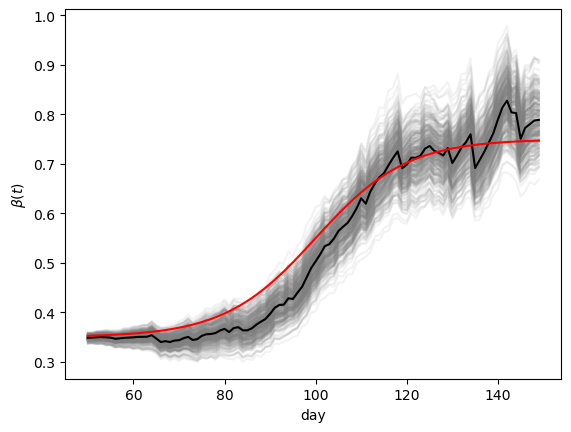

In [129]:
ens = np.asarray([θ.beta for θ in θ_list])
mean = np.mean(ens, axis=1)
t = np.arange(50,150)

fig, ax = plt.subplots()

ax.plot(t, ens[50:150,:], color="gray", alpha=0.1)
ax.plot(t, mean[50:150], color="black")
ax.plot(t, beta[50:150], color="red")
ax.set_xlabel('day')
ax.set_ylabel(r'$\beta(t)$')

In [130]:
np.argmin(np.abs(mean - 0.55))

104

In [131]:
np.argmin(np.abs(beta - 0.55))

100

In [132]:
i_ens = np.asarray([x.i for x in x_list])
prior_cov = np.var(i_ens, axis=1)